In [1]:
#import packages
import time
import requests
import sys
import pandas as pd
from Bio import AlignIO
from pymsaviz import MsaViz

In [2]:
 #functions utilized

#requests function
def get_url(url, **kwargs):
    response = requests.get(url, **kwargs)
    if not response.ok:
        print(response.text)
        response.raise_for_status()
        sys.exit()

    return response

#check the status of the alignment job
def status_check():
    if job_status.text == 'RUNNING' or job_status.text == 'QUEUED':
        print(job_status.text)
        return True
    else:
        print('FINISHED')
        return False

#show the alignment once job has completed
def show_alignment():
    query_alignment = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num")
    print(query_alignment.text)

In [13]:
#constants
UNIPROT_ENDPOINT = 'https://rest.uniprot.org'
QUERY = input("Enter the gene name").lower()
EXPECTED_LENGTH = int(input("Enter the expected length of the protein"))
MIN_SEQ_LENGTH = EXPECTED_LENGTH - (EXPECTED_LENGTH * 0.05)

In [4]:
#read and convert taxonomy csv to a dictionary
df = pd.read_csv('species_dataset.csv',
                 usecols=['Taxon Id', 'Common name', 'Scientific name'])

result = df.to_dict(orient='records')

In [5]:
#create new dictionary of only scientific name and taxon ID
taxon_id_list = []
scientific_name_list = []

for ids in result:
    for key in ids:
        if key == 'Taxon Id':
            taxon_id = ids[key]
            taxon_id_list.append(taxon_id)
        if key == 'Scientific name':
            scientific_name = ids[key]
            scientific_name_list.append(scientific_name)

taxonomy_dict = dict(zip(scientific_name_list, taxon_id_list))

In [14]:
#create an accession list which will be used to query and retrieve sequences
accession_list = []
accession_dict = {}

for tax_id in taxonomy_dict.values():
    r = get_url(f"{UNIPROT_ENDPOINT}/uniprotkb/search?query={QUERY} AND (taxonomy_id: {tax_id})")
    data = r.json()
    # n_results = len(data["results"])
    # print(f"Number of results: {n_results}\n")
    for sequences in data['results']:
        protein_existence = sequences['proteinExistence']

        if (protein_existence == '1: Evidence at protein level' or
                protein_existence == '2: Evidence at transcript level' or
                protein_existence == '3: Inferred from homology'):

            try:
                seq_len = int(sequences['sequence']['length'])
                gene_name = (sequences['genes'][0]['geneName']['value']).lower()
                
                if  gene_name == QUERY:
            
                    if seq_len >= MIN_SEQ_LENGTH:
                        accession_id = sequences['primaryAccession']
                        sequence = sequences['sequence']
                        accession_dict[accession_id] = sequence
                        accession_list.append(sequences['primaryAccession'])
                        break
            except KeyError:
                break
print(accession_list)

['A0A2K5S7L7', 'A0A2K6LU90', 'A0A2K6PPQ6', 'G1S6B4', 'G1NUL2', 'A0A0D9QXY5', 'I3NA76', 'A0A2K6SHB3', 'A0A2K5C0R9', 'H0WRK3', 'A0A3Q2TUG3', 'A0A6I8N4W5', 'G3VWI9', 'F6VV15', 'A0A2K5MBL7', 'G7PIV1', 'F7H9S4', 'A0A2K6DEE4', 'A0A2I3N1J9', 'A0A2K6ALE6', 'A0A2R9CQH3', 'P58166', 'A0A8C0SGB0', 'D2H382', 'A0A8U0N900', 'M3VZY2', 'G3T0X6', 'F1SKG1', 'E1BFT5', 'W5PA02', 'G1SSX9', 'O08717', 'O88959', 'A0A286XI29']


In [15]:
#join the list and create a fasta
joined = ','.join(accession_list)
align_response = get_url(f"{UNIPROT_ENDPOINT}/uniprotkb/accessions?accessions={joined}&format=fasta")
fasta = align_response.text
with open(f'{QUERY}_unaligned.fasta', 'w+') as file:
    file.writelines(fasta)
print(fasta)

>tr|A0A2K5S7L7|A0A2K5S7L7_CEBIM Inhibin subunit beta E OS=Cebus imitator OX=2715852 GN=INHBE PE=3 SV=1
MGLPDVQLWLVLLWALVQAHGTGSVCPSCGGPTLAPQAERALVLELAKQQILEGLHLSSR
PRITHPPPQAALTRALRRLQPGSVAPGNGEEVISFATVTDSTSACSSLLTFHLSTPWSHH
LYQARLWLHVLPTRPGTLYLRIFRWGPSRRRQGSLTLLAEHHITHLGWHALTLPSSGLRG
EESGVLKLQLDCGPLEGNGTVTGQPRQLLDTAGHQQPFLELKIQANEPGAGRARRRTPTC
GPATPLCCRRDHYIDFRELGWRDWILQPEGYQLNYCSGECPLHLAGSPGIAASFHSAVFS
LLKANNRWPASTSCCVPTARRPLSLLYLDRNGNVVKTDVPDMVVEACGCS
>tr|A0A2K6LU90|A0A2K6LU90_RHIBE Inhibin subunit beta E OS=Rhinopithecus bieti OX=61621 GN=INHBE PE=3 SV=1
MGLPDVQLWLVLLWTLVRAQGTGSVCPSCGGSKLAPQAERALVLELAKQQILEGLHLTSR
PRITHPPPQAALTRALRRLQPGSVAPGNGEEVISFATVTDSTSAYSSLLTFHLSTPRSHH
LYHARLWLHVLPTLPGTLCLRIFRWGPRRRHQGSRTLLTEHHITNLGWHALTLPSSGLRG
EKSGVLKLQLDCRPLEGNNSTVTGQPRQLLDTAGHQQPFLELKIRANEPGAGRARRRTPT
CEPATPLCCRRDHYVDFQELGWRDWILQPEGYQLNYCSGQCPLHLAGSPGIAASFHSAVF
SLLKANNPWPASTSCCVPTARRPLSLLYLDHNGNVVKTDVPDMVVEACGCS
>tr|A0A2K6PPQ6|A0A2K6PPQ6_RHIRO Inhibin subunit beta E OS=Rhinopithecus roxell

In [16]:
#submit and monitor job status
response_alignment = requests.post("https://www.ebi.ac.uk/Tools/services/rest/clustalo/run", data={
    "email": "example@example.com",
    "iterations": 0,
    "outfmt": "clustal_num",
    "order": "aligned",
    "sequence": fasta
})

job_id = response_alignment.text
job_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}")

while status_check():
    job_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}")
    time.sleep(3)

RUNNING
RUNNING
RUNNING
FINISHED


In [17]:
#show alignment
show_alignment()

CLUSTAL O(1.2.4) multiple sequence alignment


tr|F7H9S4|F7H9S4_MACMU              MTSSLLLAFFLLAPTTVATPRAGGQCPACGGPTLELESQRELLLHLAKRSILDKLHLSQR	60
tr|A0A3Q2TUG3|A0A3Q2TUG3_CHICK      MATRCALPWLL---AAAVLCGAAERCPSCGAG-----TERRLLEEAAKRQLLDGLRLRER	52
tr|A0A6I8N4W5|A0A6I8N4W5_ORNAN      --GPGPSPDL-MLLLLGWT--REPPCPSCSAAPLAPSLERAVLLELAKQQILRGLRLPAP	55
tr|G3VWI9|G3VWI9_SARHA              MGYPDVWLLLVLLWALVGAQRAGPRCPSCGLSTLGPQEERALVLELAKQQILEGLQLTSP	60
tr|A0A286XI29|A0A286XI29_CAVPO      MGLPNAQLWLMLLWALVWVQGVGSACPSCGSPALALQAERTLMLELAKQQILKGLHLTSR	60
tr|G1NUL2|G1NUL2_MYOLU              MGLPGVQLRLVLLWALTWAQETRSVCPSCGGPTLAPQAERALVLELAKQQILEGLHLTGR	60
sp|O08717|INHBE_MOUSE               MKLPKAQLWLILLWALVWVQSTRSACPSCGGPTLAPQGERALVLELAKQQILEGLHLTSR	60
sp|O88959|INHBE_RAT                 MGLSNVQLWTILLWALAWVQSTRSACPSCGAPTLTPQGERALVLELAKQQILEGLHLTSR	60
tr|G1SSX9|G1SSX9_RABIT              MGLPDVQLCLVLLWTLGWARRAGSECPACGGPTLAPQAERAVVLELAKQQILEGLHLTSR	60
tr|I3NA76|I3NA76_ICTTR              --LKRPQLWLVLLWVLI

In [18]:
#create text file
alignment = (get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num")).text

with open(f'{QUERY}_aligned_MSA.aln', 'w+') as file:
    file.writelines(alignment)

In [19]:
#turn MSA file into fasta file using BioPython
def convert_clustal_to_fasta(input_file, output_file):
    # Parse the CLUSTAL file and read the alignment
    clustal_alignment = AlignIO.read(input_file, "clustal")

    # Write the alignment in FASTA format
    with open(output_file, "w") as fasta_file:
        AlignIO.write(clustal_alignment, fasta_file, "fasta")

if __name__ == "__main__":
    input_clustal_file = f"{QUERY}_aligned_MSA.aln"
    output_fasta_file = f"{QUERY}_aligned_fasta.fasta"

    convert_clustal_to_fasta(input_clustal_file, output_fasta_file)

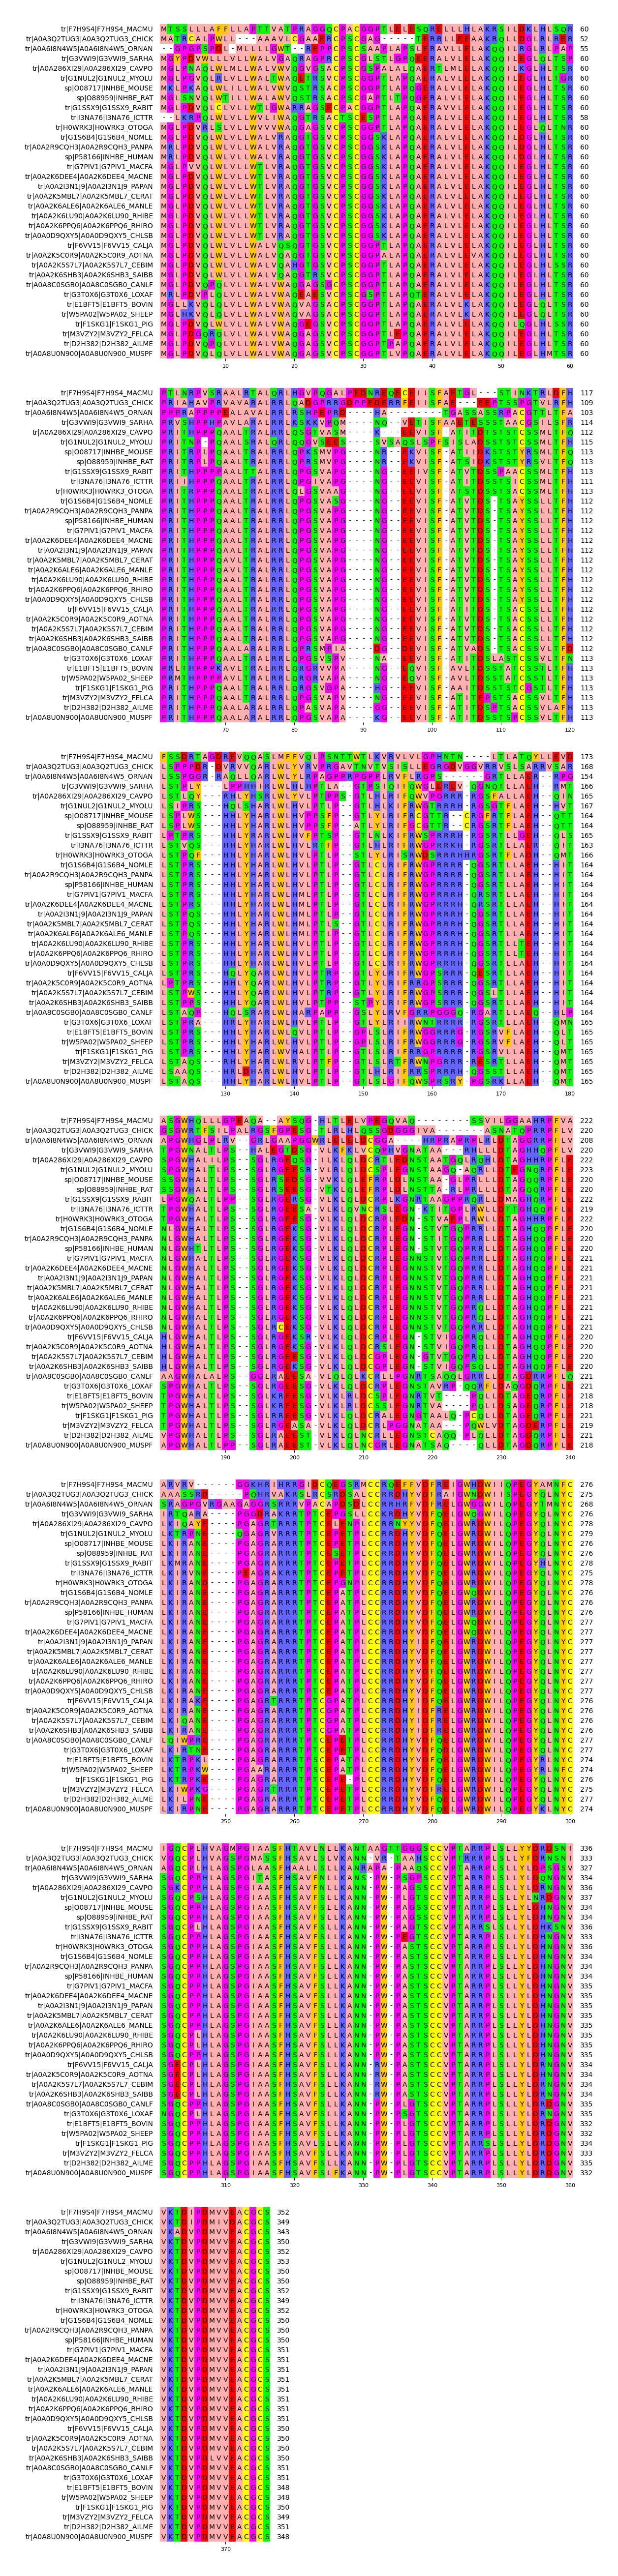

In [20]:
msa_file = open(output_fasta_file)
mv = MsaViz(msa_file, wrap_length=60, show_count=True)
mv.savefig(f"{QUERY}.png")